<a href="https://colab.research.google.com/github/tanakakao/test/blob/main/vgg_pytorch1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch_lightning
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import random_split, DataLoader
#import torchmetrics

from torchsummary import summary
import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy
import torchvision
from torchvision import models, transforms
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt

     |████████████████████████████████| 582 kB 4.2 MB/s 
     |████████████████████████████████| 408 kB 72.0 MB/s 
     |████████████████████████████████| 596 kB 36.0 MB/s 
     |████████████████████████████████| 136 kB 86.7 MB/s 
     |████████████████████████████████| 1.1 MB 11.3 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 271 kB 79.2 MB/s 
     |████████████████████████████████| 144 kB 81.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [30]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.layers1 = []
        in_channels = 3
        
        # 第1層
        conv2d = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(64), nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(64), nn.ReLU(inplace=True)]
        self.layers1 += [nn.MaxPool2d(kernel_size=2, stride=2)]
        
        # 第2層
        conv2d = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(128), nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(128), nn.ReLU(inplace=True)]
        self.layers1 += [nn.MaxPool2d(kernel_size=2, stride=2)]
        
        # 第3層
        conv2d = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(256), nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(256), nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(256), nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(256), nn.ReLU(inplace=True)]
        self.layers1 += [nn.MaxPool2d(kernel_size=2, stride=2)]
        
        # 第4層
        conv2d = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(512), nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(512), nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(512), nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(512), nn.ReLU(inplace=True)]
        self.layers1 += [nn.MaxPool2d(kernel_size=2, stride=2)]
        
        # 第5層
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(512), nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(512), nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(512), nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.BatchNorm2d(512), nn.ReLU(inplace=True)]
        self.layers1 += [nn.MaxPool2d(kernel_size=2, stride=2)]
        self.layers1 += [nn.AdaptiveAvgPool2d((7, 7))]
        self.features = nn.Sequential(*self.layers1)

        # 全結合層
        self.layers2 = []
        
        conv5 = nn.Linear(512*7*7, 4096)
        conv6 = nn.Linear(4096, 4096)
        conv7 = nn.Linear(4096, 10)
        self.layers2 += [conv5, nn.ReLU(inplace=True), nn.Dropout(p=0.5),
                         conv6, nn.ReLU(inplace=True), nn.Dropout(p=0.5), conv7]
        self.classifier = nn.Sequential(*self.layers2)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.shape[0], -1)
        out = self.classifier(out)
        return out

In [31]:
class VGGTrainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = VGG()
        
    def forward(self, x):
        #x = x.to(device)
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        preds = preds.cpu()
        y = y.cpu()
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loss, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)

        preds = preds.cpu()
        y = y.cpu()
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        preds = preds.cpu()
        y = y.cpu()
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        return optimizer

In [15]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = './'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.262])
        ])
        
        self.dims = (3, 32, 32)
        self.num_classes = 10
    
    def prepare_data(self):
        CIFAR10(self.data_dir, train= True, download= True)
        CIFAR10(self.data_dir, train= False, download= True)
    
    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            cifar_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.cifar_test = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=self.batch_size, num_workers=4)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Files already downloaded and verified
Files already downloaded and verified


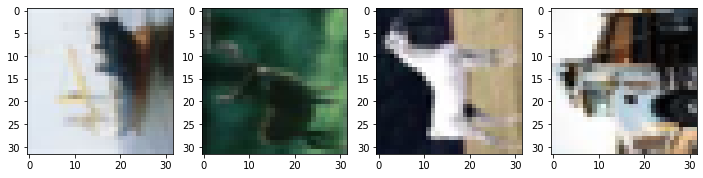

In [16]:
# Init our data pipeline
dm = CIFAR10DataModule(batch_size=64)
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup()

# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]

fig, axes = plt.subplots(1, 4, figsize=(12,3))
[axes[i].imshow(val_imgs[i].transpose(0,2)) for i in range(4)];

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = VGGTrainer().to(device)

trainer = pl.Trainer(accelerator='gpu', devices=1,max_epochs=30)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(net, dm)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | VGG  | 139 M 
-------------------------------
139 M     Trainable params
0         Non-trainable params
139 M     Total params
558.489   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

valid Loss: 2.3031 valid Acc: 0.1016


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

valid Loss: 1.4643 valid Acc: 0.4614
---------- Current Epoch 1 ----------
train Loss: 1.7825 train Acc: 0.2984


Validation: 0it [00:00, ?it/s]

valid Loss: 1.1392 valid Acc: 0.6000
---------- Current Epoch 2 ----------
train Loss: 1.2512 train Acc: 0.5460


Validation: 0it [00:00, ?it/s]

valid Loss: 0.8503 valid Acc: 0.7098
---------- Current Epoch 3 ----------
train Loss: 0.9692 train Acc: 0.6660


Validation: 0it [00:00, ?it/s]

valid Loss: 0.8309 valid Acc: 0.7154
---------- Current Epoch 4 ----------
train Loss: 0.7911 train Acc: 0.7385


Validation: 0it [00:00, ?it/s]

valid Loss: 0.7419 valid Acc: 0.7616
---------- Current Epoch 5 ----------
train Loss: 0.6560 train Acc: 0.7873


Validation: 0it [00:00, ?it/s]

valid Loss: 0.7662 valid Acc: 0.7724
---------- Current Epoch 6 ----------
train Loss: 0.5605 train Acc: 0.8199


Validation: 0it [00:00, ?it/s]

valid Loss: 0.7252 valid Acc: 0.7746
---------- Current Epoch 7 ----------
train Loss: 0.4791 train Acc: 0.8490


Validation: 0it [00:00, ?it/s]

valid Loss: 0.7613 valid Acc: 0.7776
---------- Current Epoch 8 ----------
train Loss: 0.4051 train Acc: 0.8704


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6443 valid Acc: 0.8110
---------- Current Epoch 9 ----------
train Loss: 0.3514 train Acc: 0.8906


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6210 valid Acc: 0.8074
---------- Current Epoch 10 ----------
train Loss: 0.3080 train Acc: 0.9039


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6763 valid Acc: 0.8160
---------- Current Epoch 11 ----------
train Loss: 0.2647 train Acc: 0.9184


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6946 valid Acc: 0.8110
---------- Current Epoch 12 ----------
train Loss: 0.2260 train Acc: 0.9310


Validation: 0it [00:00, ?it/s]

valid Loss: 0.7144 valid Acc: 0.8050
---------- Current Epoch 13 ----------
train Loss: 0.2038 train Acc: 0.9358


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6878 valid Acc: 0.8186
---------- Current Epoch 14 ----------
train Loss: 0.1844 train Acc: 0.9448


Validation: 0it [00:00, ?it/s]

valid Loss: 0.7174 valid Acc: 0.8156
---------- Current Epoch 15 ----------
train Loss: 0.1916 train Acc: 0.9430


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6876 valid Acc: 0.8180
---------- Current Epoch 16 ----------
train Loss: 0.1427 train Acc: 0.9563


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6153 valid Acc: 0.8320
---------- Current Epoch 17 ----------
train Loss: 0.1263 train Acc: 0.9622


Validation: 0it [00:00, ?it/s]

valid Loss: 0.7583 valid Acc: 0.8186
---------- Current Epoch 18 ----------
train Loss: 0.1511 train Acc: 0.9571


Validation: 0it [00:00, ?it/s]

valid Loss: 0.7230 valid Acc: 0.8276
---------- Current Epoch 19 ----------
train Loss: 0.1514 train Acc: 0.9575


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6997 valid Acc: 0.8298
---------- Current Epoch 20 ----------
train Loss: 0.1014 train Acc: 0.9707


Validation: 0it [00:00, ?it/s]

valid Loss: 1.0034 valid Acc: 0.7910
---------- Current Epoch 21 ----------
train Loss: 0.0857 train Acc: 0.9740


Validation: 0it [00:00, ?it/s]

valid Loss: 0.8859 valid Acc: 0.8096
---------- Current Epoch 22 ----------
train Loss: 0.1571 train Acc: 0.9527


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6607 valid Acc: 0.8358
---------- Current Epoch 23 ----------
train Loss: 0.1134 train Acc: 0.9703


Validation: 0it [00:00, ?it/s]

valid Loss: 0.7114 valid Acc: 0.8386
---------- Current Epoch 24 ----------
train Loss: 0.0657 train Acc: 0.9803


Validation: 0it [00:00, ?it/s]

valid Loss: 0.8060 valid Acc: 0.8310
---------- Current Epoch 25 ----------
train Loss: 0.0724 train Acc: 0.9790


Validation: 0it [00:00, ?it/s]

valid Loss: 0.7445 valid Acc: 0.8346
---------- Current Epoch 26 ----------
train Loss: 0.0660 train Acc: 0.9799


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6843 valid Acc: 0.8404
---------- Current Epoch 27 ----------
train Loss: 0.1266 train Acc: 0.9672


Validation: 0it [00:00, ?it/s]

valid Loss: 0.7246 valid Acc: 0.8402
---------- Current Epoch 28 ----------
train Loss: 0.0819 train Acc: 0.9775


Validation: 0it [00:00, ?it/s]

valid Loss: 1.0683 valid Acc: 0.8126
---------- Current Epoch 29 ----------
train Loss: 0.0619 train Acc: 0.9822


Validation: 0it [00:00, ?it/s]

valid Loss: 0.7443 valid Acc: 0.8220
---------- Current Epoch 30 ----------
train Loss: 0.1270 train Acc: 0.9663
